In [1]:
# import os
# os.environ['PATH'] += ':ffmpeg-3.4.2-64bit-static'

# Setup

In [2]:
exp_directory = 'dummy'
agent_name = 'DeepQAgent'
game_name = 'SuperMarioBros-1-1'
render_mode='rgb_array'

### Global Modules

In [3]:
import os
import datetime
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from gym.wrappers import Monitor

### Local Modules

In [4]:
import base
from src.agents import DeepQAgent, A3CAgent
from src.util import BaseCallback, JupyterCallback
from src.environment.nes import build_nes_environment

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constants

In [5]:
agents = {
    DeepQAgent.__name__: DeepQAgent,
    A3CAgent.__name__: A3CAgent,
}

#### Output Directory

In [6]:
# setup the experiment directory
now = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M')
exp_directory = '{}/{}/{}/{}'.format(exp_directory, game_name, agent_name, now)
if not os.path.exists(exp_directory):
    os.makedirs(exp_directory)
exp_directory

'dummy/SuperMarioBros-1-1/DeepQAgent/2018-04-20_19-57'

In [7]:
plot_dir = '{}/plots'.format(exp_directory)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'dummy/SuperMarioBros-1-1/DeepQAgent/2018-04-20_19-57/plots'

# Environment

In [8]:
env = build_nes_environment(game_name)
# env = Monitor(env, '{}/monitor'.format(exp_directory), force=True)

[2018-04-20 19:57:15,644] Making new env: SuperMarioBros-1-1-v0


In [9]:
env.observation_space

Box(100, 100, 4)

In [10]:
env.action_space

Discrete(14)

# Agent

In [11]:
agent = agents[agent_name](env, render_mode=render_mode)
agent

DeepQAgent(
    env=<FrameStackEnv<ClipRewardEnv<DownsampleEnv<ToDiscreteWrapper<TimeLimit<SuperMarioBrosEnv instance>>>>>>,
    render_mode='rgb_array'
    replay_memory_size=1000000,
    discount_factor=0.99,
    update_frequency=4,
    optimizer=<keras.optimizers.Adam object at 0x7fb2583a8390>,
    exploration_rate=AnnealingVariable(initial_value=1.0, final_value=0.1, steps=1000000),
    loss=huber_loss,
    target_update_freq=10000,
    dueling_network=True
)

In [12]:
# write some info about the agent to disk
with open('{}/agent.py'.format(exp_directory), 'w') as agent_file:
    agent_file.write(repr(agent))

## Initial

In [13]:
initial = agent.play(games=5)
initial = pd.Series(initial)
initial

100%|██████████| 5/5 [06:53<00:00, 82.63s/game]


0   -10.0
1    -4.0
2   -18.0
3    -2.0
4   -39.0
dtype: float64

In [14]:
initial.to_csv('{}/initial.csv'.format(exp_directory))

In [15]:
initial.describe()

count     5.000000
mean    -14.600000
std      14.993332
min     -39.000000
25%     -18.000000
50%     -10.000000
75%      -4.000000
max      -2.000000
dtype: float64

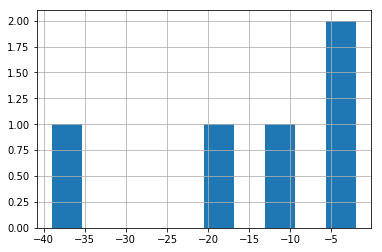

In [ ]:
initial.hist()
plt.savefig('{}/initial.pdf'.format(plot_dir))

## Training

In [ ]:
agent.observe()

 44%|████▍     | 22091/50000 [06:31<09:58, 46.62frame/s]  

In [ ]:
callback = BaseCallback()

In [ ]:
agent.train(callback=callback)

In [ ]:
# save the training results
scores = pd.Series(callback.scores)
scores.to_csv('{}/scores.csv'.format(exp_directory))
losses = pd.Series(callback.losses)
losses.to_csv('{}/losses.csv'.format(exp_directory))

In [ ]:
train = pd.concat([scores, losses], axis=1)
train.columns = ['Reward', 'Loss']
train.index.name = 'Episode'
_ = train.plot(figsize=(12, 5), subplots=True)
plt.savefig('{}/training.pdf'.format(plot_dir))

## Final

In [ ]:
final = agent.play(games=5)
final = pd.Series(final)
final

In [ ]:
final.to_csv('{}/final.csv'.format(exp_directory))

In [ ]:
final.describe()

In [ ]:
final.hist()
plt.savefig('{}/final.pdf'.format(plot_dir))

## Saving Weights

In [ ]:
agent.model.save_weights('{}/weights.h5'.format(exp_directory), overwrite=True)